# 02 - Classificando patologias em toras usando combinação de `LBP + SVM` e normalizando amostras pela dimensão da imagem (quantidade de píxels)

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'broca': 0,
                'fissura': 1,
                'musgo': 2,
                'quebra': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./patologias.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./patologias.zip/{path}')


# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)
amostra = []

for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img:np.ndarray = io.imread(path, as_gray=True)
    
    lbp = local_binary_pattern(image=img, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = np.zeros(59)
    for i in hist.index:
      arr[int(i)] = hist[i]

    # Realizando normalização pela quantidade de píxeis
    arr /= np.product(img.shape)

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/lbp_norm1_toras.csv')
data

broca: 298 amostras
fissura: 2766 amostras
musgo: 505 amostras
quebra: 679 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,0.052039,0.045649,0.000673,0.005801,0.002270,0.041950,0.001934,0.005801,0.001850,0.008911,...,0.004792,0.002774,0.036654,0.001934,0.004372,0.002606,0.038335,0.063388,0.111475,0
1,0.054317,0.044345,0.001398,0.004797,0.001133,0.044496,0.001133,0.006308,0.001889,0.008914,...,0.005779,0.002569,0.041324,0.002342,0.004495,0.002342,0.039322,0.065045,0.115510,0
2,0.049136,0.034217,0.001279,0.007246,0.001976,0.034488,0.001279,0.005464,0.001550,0.009533,...,0.006859,0.003023,0.027629,0.002829,0.005774,0.003798,0.027087,0.059095,0.105673,0
3,0.053608,0.036504,0.001239,0.009926,0.001110,0.035704,0.001278,0.010688,0.001149,0.006790,...,0.006093,0.004699,0.029960,0.004634,0.005563,0.004440,0.030063,0.078237,0.129908,0
4,0.061811,0.034659,0.001905,0.009486,0.002764,0.033838,0.002204,0.010719,0.002614,0.009860,...,0.010271,0.003436,0.028385,0.002540,0.009113,0.003100,0.032456,0.067227,0.121830,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,0.066404,0.038633,0.002041,0.005030,0.002478,0.036519,0.002770,0.003936,0.002260,0.006196,...,0.004738,0.002697,0.027553,0.002114,0.005758,0.003353,0.029448,0.077411,0.127852,3
1188,0.068981,0.034646,0.002119,0.007166,0.003053,0.038385,0.002243,0.005920,0.002368,0.006107,...,0.006792,0.003926,0.030035,0.003614,0.006792,0.003863,0.026608,0.086117,0.137400,3
1189,0.059469,0.028742,0.001672,0.007943,0.001463,0.027906,0.003031,0.009720,0.002508,0.010138,...,0.011915,0.003972,0.022575,0.002822,0.007421,0.002717,0.019649,0.067726,0.119252,3
1190,0.073523,0.038470,0.002315,0.004850,0.002425,0.042549,0.003197,0.006063,0.002315,0.006834,...,0.005511,0.003307,0.030093,0.002315,0.006283,0.002976,0.031856,0.086089,0.145613,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 338
              precision    recall  f1-score   support

       broca       0.99      0.94      0.96        85
     fissura       0.94      0.97      0.96        79
       musgo       0.97      0.97      0.97       105
      quebra       0.98      0.99      0.98        89

    accuracy                           0.97       358
   macro avg       0.97      0.97      0.97       358
weighted avg       0.97      0.97      0.97       358



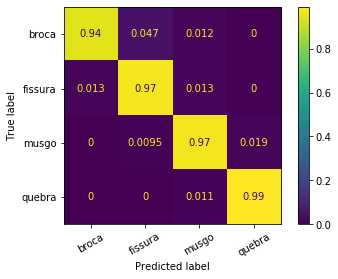

Rodada 1	-	Seed 6882
              precision    recall  f1-score   support

       broca       0.99      0.90      0.94        83
     fissura       0.91      0.97      0.94        97
       musgo       0.93      0.94      0.93        84
      quebra       0.97      0.97      0.97        94

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



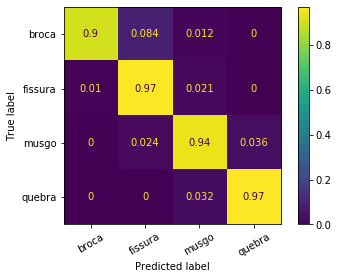

Rodada 2	-	Seed 960
              precision    recall  f1-score   support

       broca       0.99      0.95      0.97        84
     fissura       0.94      0.98      0.96        91
       musgo       0.94      0.97      0.95        93
      quebra       0.98      0.93      0.95        90

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



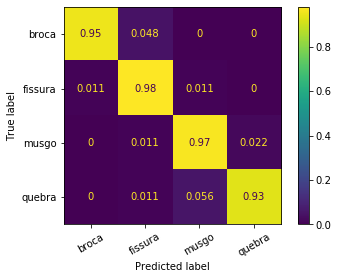

Rodada 3	-	Seed 3937
              precision    recall  f1-score   support

       broca       0.97      0.89      0.93        82
     fissura       0.90      0.97      0.93        86
       musgo       0.95      0.98      0.96        93
      quebra       0.98      0.96      0.97        97

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



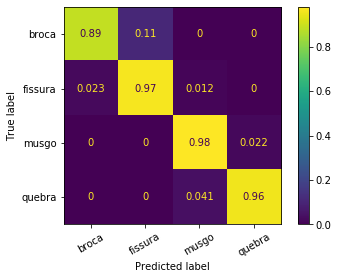

Rodada 4	-	Seed 7740
              precision    recall  f1-score   support

       broca       0.96      0.93      0.94        91
     fissura       0.94      0.92      0.93        79
       musgo       0.95      0.98      0.96       107
      quebra       0.96      0.95      0.96        81

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



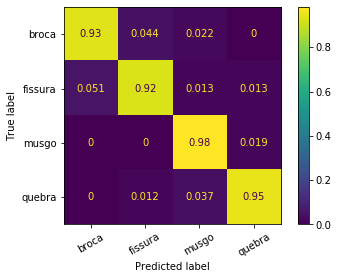

Rodada 5	-	Seed 4982
              precision    recall  f1-score   support

       broca       0.99      0.91      0.95        91
     fissura       0.92      0.98      0.95        86
       musgo       0.95      0.97      0.96        98
      quebra       0.96      0.96      0.96        83

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



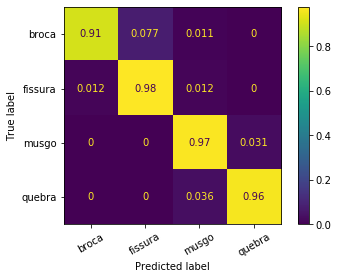

Rodada 6	-	Seed 7822
              precision    recall  f1-score   support

       broca       0.94      0.95      0.95        88
     fissura       0.95      0.94      0.94        98
       musgo       0.96      0.98      0.97        87
      quebra       0.99      0.96      0.98        85

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



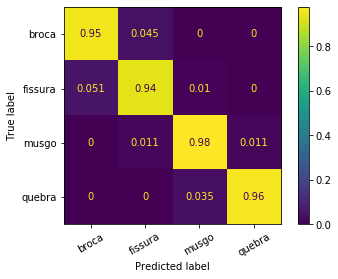

Rodada 7	-	Seed 7732
              precision    recall  f1-score   support

       broca       0.98      0.91      0.94        91
     fissura       0.93      0.97      0.95        88
       musgo       0.93      0.97      0.95        93
      quebra       0.95      0.94      0.95        86

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



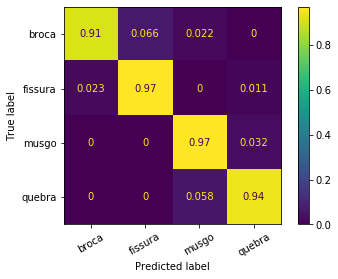

Rodada 8	-	Seed 658
              precision    recall  f1-score   support

       broca       1.00      0.91      0.95        96
     fissura       0.92      1.00      0.96        87
       musgo       0.98      0.96      0.97        97
      quebra       0.95      0.99      0.97        78

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



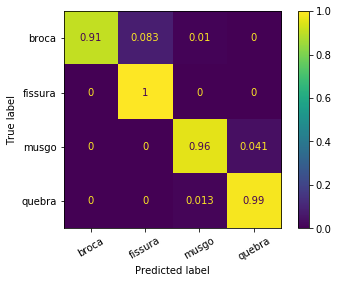

Rodada 9	-	Seed 573
              precision    recall  f1-score   support

       broca       0.96      0.90      0.93        77
     fissura       0.94      0.95      0.94        98
       musgo       0.94      0.96      0.95        97
      quebra       0.94      0.97      0.95        86

    accuracy                           0.94       358
   macro avg       0.95      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



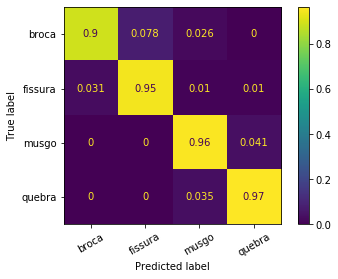

Rodada 10	-	Seed 1716
              precision    recall  f1-score   support

       broca       0.94      0.92      0.93        87
     fissura       0.93      0.95      0.94        92
       musgo       0.96      0.97      0.96        90
      quebra       0.97      0.96      0.96        89

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



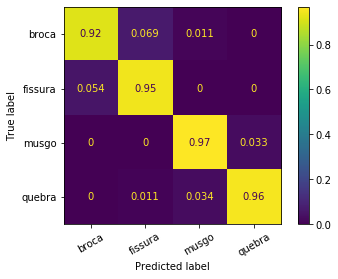

Rodada 11	-	Seed 4547
              precision    recall  f1-score   support

       broca       0.97      0.83      0.90        84
     fissura       0.84      0.96      0.90        76
       musgo       0.95      0.96      0.96       107
      quebra       0.96      0.96      0.96        91

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



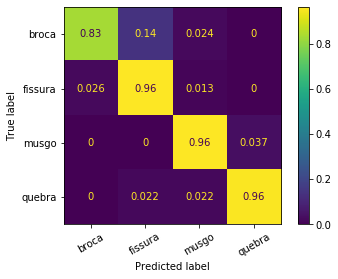

Rodada 12	-	Seed 2625
              precision    recall  f1-score   support

       broca       0.97      0.93      0.95        94
     fissura       0.92      0.95      0.94        87
       musgo       0.89      0.95      0.92        86
      quebra       0.95      0.90      0.93        91

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



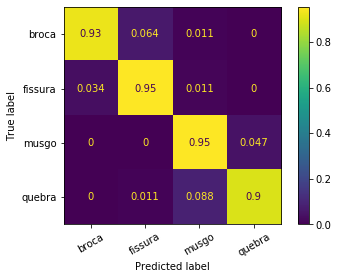

Rodada 13	-	Seed 2171
              precision    recall  f1-score   support

       broca       0.99      0.93      0.96        89
     fissura       0.92      0.99      0.95        91
       musgo       0.97      0.99      0.98        85
      quebra       1.00      0.96      0.98        93

    accuracy                           0.97       358
   macro avg       0.97      0.97      0.97       358
weighted avg       0.97      0.97      0.97       358



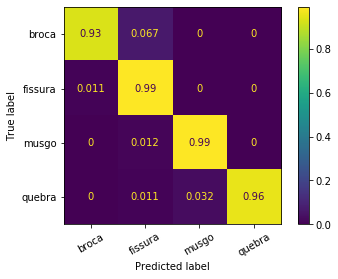

Rodada 14	-	Seed 4013
              precision    recall  f1-score   support

       broca       0.93      0.97      0.95        88
     fissura       0.97      0.91      0.94        94
       musgo       0.94      0.99      0.96        90
      quebra       0.99      0.95      0.97        86

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



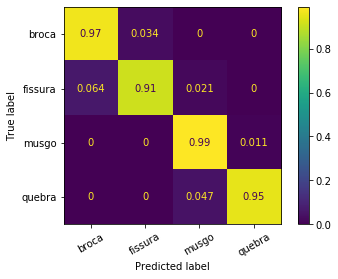

Rodada 15	-	Seed 6750
              precision    recall  f1-score   support

       broca       1.00      0.87      0.93       103
     fissura       0.85      0.94      0.89        84
       musgo       0.92      0.95      0.94        88
      quebra       0.92      0.93      0.92        83

    accuracy                           0.92       358
   macro avg       0.92      0.92      0.92       358
weighted avg       0.93      0.92      0.92       358



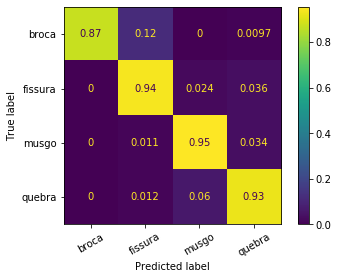

Rodada 16	-	Seed 6825
              precision    recall  f1-score   support

       broca       0.96      0.95      0.95        74
     fissura       0.94      0.95      0.95        86
       musgo       0.97      0.98      0.97        96
      quebra       0.97      0.96      0.97       102

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



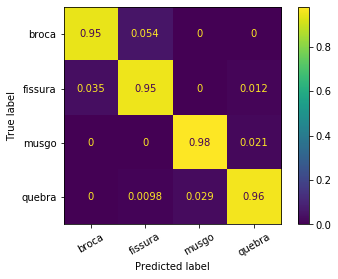

Rodada 17	-	Seed 1637
              precision    recall  f1-score   support

       broca       0.98      0.95      0.97        87
     fissura       0.94      0.98      0.96        87
       musgo       1.00      0.95      0.97        99
      quebra       0.96      1.00      0.98        85

    accuracy                           0.97       358
   macro avg       0.97      0.97      0.97       358
weighted avg       0.97      0.97      0.97       358



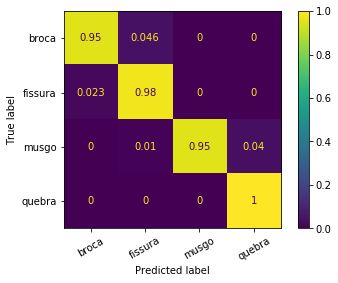

Rodada 18	-	Seed 402
              precision    recall  f1-score   support

       broca       0.95      0.92      0.94        78
     fissura       0.92      0.95      0.94       103
       musgo       0.92      0.95      0.94        87
      quebra       0.97      0.92      0.94        90

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



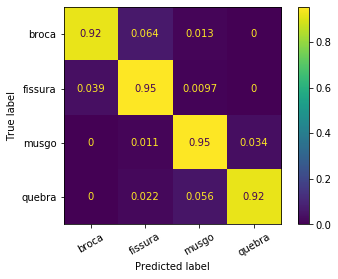

Rodada 19	-	Seed 1955
              precision    recall  f1-score   support

       broca       0.98      0.97      0.97        98
     fissura       0.98      0.97      0.97        95
       musgo       0.93      0.97      0.95        80
      quebra       0.96      0.94      0.95        85

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



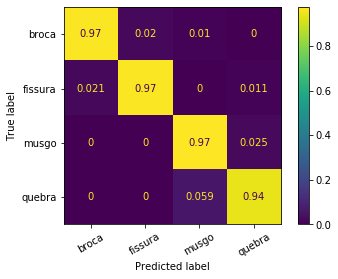

Rodada 20	-	Seed 7614
              precision    recall  f1-score   support

       broca       0.98      0.90      0.94        89
     fissura       0.90      0.95      0.93        86
       musgo       0.95      0.99      0.97        95
      quebra       0.98      0.95      0.97        88

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



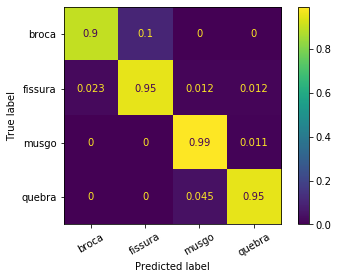

Rodada 21	-	Seed 175
              precision    recall  f1-score   support

       broca       0.98      0.90      0.94       109
     fissura       0.88      0.97      0.92        86
       musgo       0.95      1.00      0.98        84
      quebra       0.99      0.95      0.97        79

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



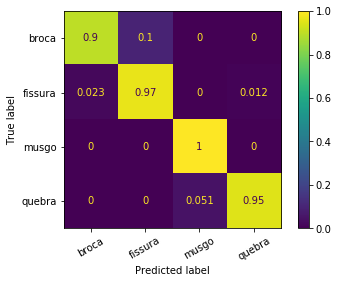

Rodada 22	-	Seed 1997
              precision    recall  f1-score   support

       broca       0.99      0.94      0.96        80
     fissura       0.92      0.99      0.95        83
       musgo       0.99      0.95      0.97       104
      quebra       0.96      0.98      0.97        91

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



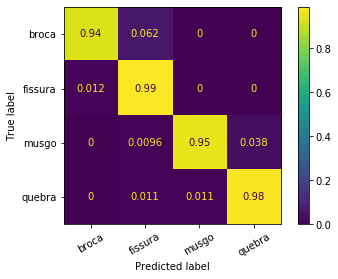

Rodada 23	-	Seed 4987
              precision    recall  f1-score   support

       broca       0.96      0.90      0.93        79
     fissura       0.90      0.91      0.91        81
       musgo       0.95      0.99      0.97        98
      quebra       0.97      0.97      0.97       100

    accuracy                           0.95       358
   macro avg       0.95      0.94      0.94       358
weighted avg       0.95      0.95      0.95       358



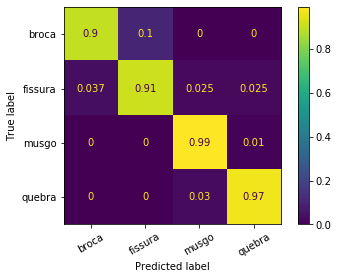

Rodada 24	-	Seed 6044
              precision    recall  f1-score   support

       broca       0.95      0.94      0.95        89
     fissura       0.93      0.94      0.93        93
       musgo       0.97      0.98      0.97        89
      quebra       0.98      0.97      0.97        87

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



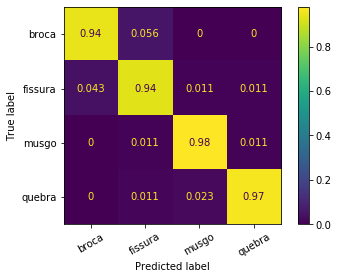

Rodada 25	-	Seed 2955
              precision    recall  f1-score   support

       broca       0.97      0.91      0.94        85
     fissura       0.90      0.96      0.93        83
       musgo       0.95      0.95      0.95        91
      quebra       0.95      0.95      0.95        99

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



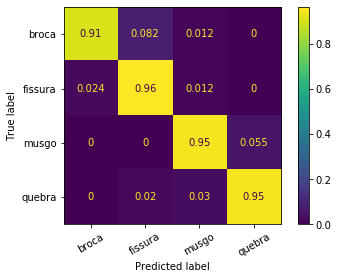

Rodada 26	-	Seed 4951
              precision    recall  f1-score   support

       broca       0.98      0.92      0.95        91
     fissura       0.92      0.96      0.94        81
       musgo       0.95      1.00      0.97        96
      quebra       1.00      0.96      0.98        90

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



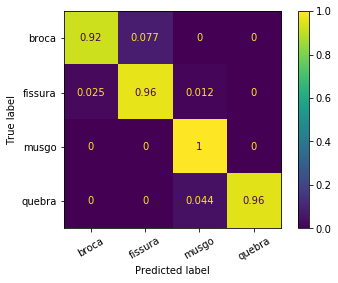

Rodada 27	-	Seed 3343
              precision    recall  f1-score   support

       broca       1.00      0.91      0.96        82
     fissura       0.91      0.99      0.95        79
       musgo       0.93      0.98      0.95        93
      quebra       0.98      0.93      0.96       104

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.96      0.95      0.95       358



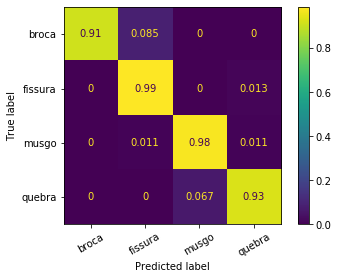

Rodada 28	-	Seed 3712
              precision    recall  f1-score   support

       broca       0.99      0.95      0.97        96
     fissura       0.94      0.98      0.96        86
       musgo       0.96      0.98      0.97        89
      quebra       0.97      0.95      0.96        87

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



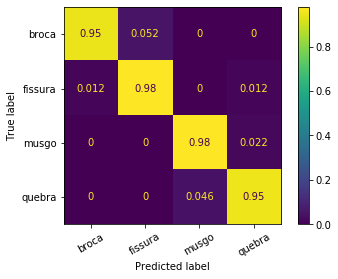

Rodada 29	-	Seed 6906
              precision    recall  f1-score   support

       broca       0.99      0.91      0.95        92
     fissura       0.92      0.98      0.95        87
       musgo       0.98      0.99      0.98        89
      quebra       0.99      1.00      0.99        90

    accuracy                           0.97       358
   macro avg       0.97      0.97      0.97       358
weighted avg       0.97      0.97      0.97       358



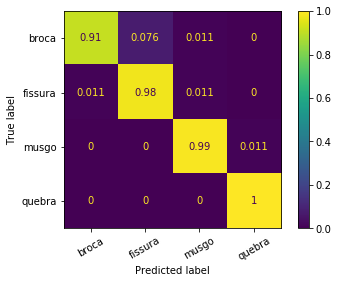

In [4]:
df = pd.read_csv('./csvs/lbp_norm1_toras.csv')
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

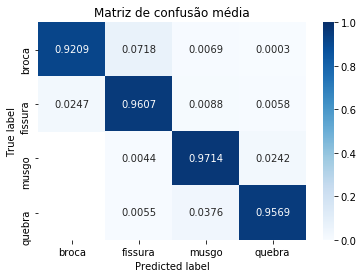

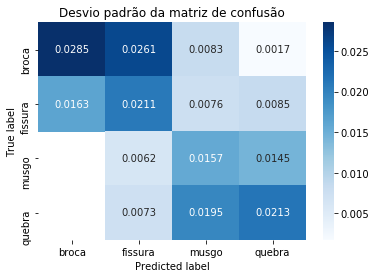

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia   f1-broca  f1-fissura   f1-musgo  f1-quebra
count  30.000000  30.000000   30.000000  30.000000  30.000000
mean    0.952607   0.946149    0.939944   0.960402   0.962369
std     0.011862   0.015856    0.018187   0.014654   0.015252
min     0.921788   0.897436    0.892655   0.921348   0.922156
25%     0.946927   0.936204    0.931007   0.951510   0.954825
50%     0.953911   0.948862    0.941795   0.963133   0.965517
75%     0.960894   0.954656    0.951716   0.971218   0.970311
max     0.969274   0.974359    0.973545   0.983240   0.994475


Acurácia,f1-broca,f1-fissura,f1-musgo,f1-quebra
0.969274,0.963855,0.956522,0.971429,0.983240
0.946927,0.943396,0.940000,0.934911,0.968085
0.958101,0.969697,0.956989,0.952381,0.954545
0.949721,0.929936,0.932584,0.962963,0.968750
0.949721,0.944444,0.929936,0.963303,0.956522
0.955307,0.948571,0.949153,0.959596,0.963855
0.958101,0.949153,0.943590,0.965909,0.976190
0.946927,0.943182,0.949721,0.947368,0.947368
0.960894,0.950820,0.956044,0.968750,0.968553
0.944134,0.926174,0.944162,0.948980,0.954023


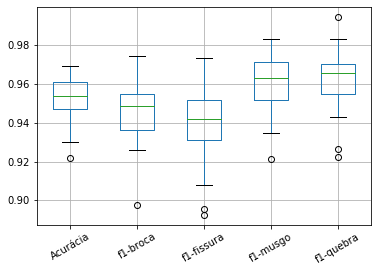

In [6]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')